In [1]:
!pip install -Uqq fastcore fastprogress datasets torcheval

## Import code from miniai

Code from `miniai.training`

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Code from `miniai.datasets`

In [3]:
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

Code from `miniai.conv`

In [4]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

___

In [5]:
#| default_exp learner

In [6]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from fastprogress import progress_bar,master_bar

In [7]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
import logging
from fastcore.test import test_close

In [8]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [9]:
logging.disable(logging.WARNING)

## Learner

In [10]:
x,y = 'image','label'
name = 'fashion_mnist'
dsd = load_dataset(name)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [12]:
bs = 1024
tds = dsd.with_transform(transformi)

In [13]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [14]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        """Train for one batch"""
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds,self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        """Compute and save loss & metric"""
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
        
    def one_epoch(self, train):
        """Train for one epoch"""
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()  # why self.num?
        n = sum(self.ns)
        print(f'{self.epoch} | {self.model.training} | {sum(self.losses).item()/n:.3f} | {sum(self.accs).item()/n:.3f}')
        
    def fit(self, n_epochs):
        """Train for n_epochs epochs"""
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        #self.n_epochs = n_epochs
        print('epoch | training? | loss | accuracy')
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [15]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [16]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

epoch | training? | loss | accuracy
0 | True | 1.175 | 0.599
0 | False | 1.120 | 0.613


## Basic Callback Learning

In [17]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [18]:
#|export
class Callback(): order = 0

In [19]:
# Note Umer: cbs is a list of callback classes, each of which have metnods.
# method_nm is the name of the method to be called
def run_cbs(cbs, method_nm, learn=None):  
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [20]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [21]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 2 batches


Note Umer: Now we'll add cbs to our Learner.<br/>
For this,
- we wrap each batch/epoch/fit with a `before_{batch/epoch/fit}` and `after_{batch/epoch/fit}`
- we wrap that again in a `try-except` and catch the `Cancel{Batch/Epoch/Fit}Exception`

In [22]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        """Train for one batch"""
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds,self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        """Compute and save loss & metric"""
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
        
    def one_epoch(self, train):
        """Train for one epoch"""
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for _,self.batch in enumerate(dl):
                try:
                    self.callback('before_batch') 
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
        n = sum(self.ns)
        print(f'{self.epoch} | {self.model.training} | {sum(self.losses).item()/n:.3f} | {sum(self.accs).item()/n:.3f}')
        
    def fit(self, n_epochs):
        """Train for n_epochs epochs"""
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        #self.n_epochs = n_epochs
        print('epoch | training? | loss | accuracy')
        try:
            self.callback('before_fit')
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [23]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [24]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

epoch | training? | loss | accuracy
0 | True | 1.191 | 0.601
0 | False | 1.129 | 0.619
Completed 64 batches


## Metrics

In [25]:
# Note Umer: a class to accumulate metric data
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp,targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [26]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [27]:
acc = Accuracy()
print(acc.value)
acc.add(tensor([0,1,2,0,1,2]), tensor([0,1,1,2,1,0]))
print(acc.value)
acc.add(tensor([1,1,2,0,1]), tensor([0,1,1,2,1]))
acc.value

tensor(nan)
tensor(0.50)


tensor(0.45)

We can also represent the loss as a metric. Here, we don't compute anything, but just pass in the loss values.

In [28]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2),2)

(tensor(0.62), 0.62)

## Some callbacks

The metrics in `torcheval` work the same way

In [29]:
from torcheval.metrics import MulticlassAccuracy,Mean

In [30]:
metric = MulticlassAccuracy()
metric.update(tensor([0,2,1,3]), tensor([0,1,2,3]))
metric.compute()

tensor(0.50)

In [31]:
metric.reset()
metric.compute()

tensor(nan)

In [32]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [33]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o  # add metrics passes as args to 'metrics'-kwargs
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self,d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]  # metrics are accumulating, so we need to reset them before use
        
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'traing' if learn.model.training else 'eval'
        self._log(log)
        
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [34]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self,learn): learn.batch = to_device(learn.batch, device=self.device)

In [35]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

epoch | training? | loss | accuracy
{'accuracy': '0.614', 'loss': '1.163', 'epoch': 0, 'train': 'traing'}
0 | True | 1.163 | 0.614
{'accuracy': '0.703', 'loss': '0.888', 'epoch': 0, 'train': 'eval'}
0 | False | 1.124 | 0.626


Let's remove the print statements from `Learner`

In [36]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        """Train for one batch"""
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds,self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        """Compute and save loss & metric"""
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
        
    def one_epoch(self, train):
        """Train for one epoch"""
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for _,self.batch in enumerate(dl):
                try:
                    self.callback('before_batch') 
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
        n = sum(self.ns)
        
    def fit(self, n_epochs):
        """Train for n_epochs epochs"""
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [37]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.611', 'loss': '1.187', 'epoch': 0, 'train': 'traing'}
{'accuracy': '0.684', 'loss': '0.825', 'epoch': 0, 'train': 'eval'}


## Flexible learner

Note Umer: We're wrapping something (the fit, epoch, batch execution) into something else. This is a good use case for context managers.<br/>
So, we'll now refactor the above code with context managers.

Note Umer: Here, we also use `globals()`, which is a `dict` mapping each global variable name to its content.

In [38]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_exit_code', '_i2', 'pickle', 'gzip', 'math', 'os', 'time', 'shutil', 'torch', 'mpl', 'np', 'plt', 'Path', 'tensor', 'nn', 'F', 'accuracy', 'report', 'Dataset', 'DataLoader', 'SequentialSampler', 'RandomSampler', 'BatchSampler', 'fit', 'get_dls', '_i3', 'annotations', 'itemgetter', 'zip_longest', 'fc', 'default_collate', 'inplace', 'collate_dict', 'show_image', 'subplots', 'get_grid', 'show_images', 'DataLoaders', '_i4', 'Mapping', 'conv', 'def_device', 'to_device', 'collate_device', '_i5', '_i6', 'attrgetter', 'partial', 'copy', 'optim', 'progress_bar', 'master_bar', '_i7', 'TF', 'contextmanager', 'load_dataset', 'load_dataset_builder', 'logging', 'test_close', '_i8', '_i9', '_i10', 'x', 'y', 'name', 'dsd', '_i11', 'transformi', '_i12', 'bs', 'tds', '_i13', 'dls'

In [39]:
globals()['run_cbs']

<function __main__.run_cbs(cbs, method_nm, learn=None)>

In [40]:
class Learner():
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, cbs=None, optim_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception'] : pass
        finally: self.callback(f'cleanup_{nm}')

    def one_batch(self):
        with self.cb_ctx('batch'):
            # xb,yb = to_device(self.batch) # <- will be done via callback
            xb,yb = self.batch
            self.preds = self.model(xb)
            self.loss = self.loss_func(self.preds, yb)
            if self.model.train:
                self.loss.backward()
                self.optim.step()
                self.model.zero_grad()
    
    def one_epoch(self, train):
        self.model.train = train
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.batch in self.dl: self.one_batch()

    def fit(self, n_epochs, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.optim = self.optim_func(self.model.parameters(), lr=self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                # self.models.to(def_device) # <- will be done via callback
                for self.epoch in range(n_epochs):
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)
        
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
        
    @property
    def training(self): return self.model.training

Note Umer:
- We used the context manager `torch.no_grad` in its non-decorator form, which allowed us to put everything on one line: `torch.no_grad()(self.one_epoch)(False)`

- We are saving `preds`, `loss` and `epoch` into the `Learner`, as they're accessed by the metrics cb, not because the `Learner` itself needs that

- Same for property `training`

- This is not quite Jeremy's implementation, as he (i) saves more variables to the class and (ii) places the `predict`, `loss` and `zero_grad` exection outside of the Learner, into callbacks

But it should run! Let's try.

In [41]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.607', 'loss': '1.164', 'epoch': 0, 'train': 'traing'}
{'accuracy': '0.725', 'loss': '0.765', 'epoch': 0, 'train': 'traing'}


Okay, let's now go full Jeremy and outsource `predict`, `loss`, `backward`, `step` and `zero_grad` into callbacks as well.<br/>
I think the reasoning behind outsourcing as much as possible into cbs and saving as much as possible, is it gives us more experimental control and insight into the model.

In [64]:
class Learner():
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception'] : pass
        finally: self.callback(f'cleanup_{nm}')

    def one_batch(self):
        with self.cb_ctx('batch'):
            self.predict()
            self.get_loss()
            if self.training:
                self.backward()
                self.step()
                self.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl): self.one_batch()

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs=n_epochs
            self.epochs=range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), lr=self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    # Defer 'predict','get_loss','backward','step','zero_grad' to callbacks
    # Note: In theory, multiple Training CBs could be passed, which is not what the want.
    # But as long, as we use it correctly (ie only pass exactly 1 training), it's fine.
    #
    # Also note `__getattr__` is only called when accessing attrs that don't exist
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
        
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
        
    @property
    def training(self): return self.model.training

In [65]:
class TrainCB(Callback):
    def predict(self,learn): learn.preds = learn.model(learn.batch[0])
    def get_loss(self,learn): learn.loss = learn.loss_function(learn.preds, learn.batch[1])
    def backward(self,learn): learn.loss.backward()
    def step(self,learn): learn.opt.step()
    def zero_grad(self,learn): learn.model.zero_grad()

That's the 1-input version. Let's extend it to possibly multiple inputs.

In [66]:
class TrainCB(Callback):
    def __init__(self,n_inp=1): self.n_inp=n_inp
    def predict(self,learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self,learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self,learn): learn.loss.backward()
    def step(self,learn): learn.opt.step()
    def zero_grad(self,learn): learn.model.zero_grad()

In [67]:
class ProgressCB(Callback):
    order = MetricsCB.order+1  # Compute metrics first, then show them afterwards 
    def __init__(self, plot=False): self.plot=plot
    def before_fit(self,learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        # Q: It seems this depends on the MetricsCB variable passed to Learner to be called `metrics`?
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []
    
    def _log(self,d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first=False
        self.mbar.write(list(d.values()), table=True)
        
    def before_epoch(self,learn):learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self,learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            # only update after each epoch. Q: Why is this here & not in after_epoch?
            if self.val_losses: self.mbar.update_graph([
                # plot train losses
                [fc.L.range(self.losses), self.losses],
                # plot val losses & align their position with train losses
                [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]
            ])

    def after_epoch(self,learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([
                    # plot train losses
                    [fc.L.range(self.losses), self.losses],
                    # plot val losses & align their position with train losses
                    [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]
                ])

In [68]:
model = get_model()

accuracy,loss,epoch,train
0.618,1.152,0,traing
0.715,0.781,0,eval
0.750,0.708,1,traing
0.742,0.701,1,eval


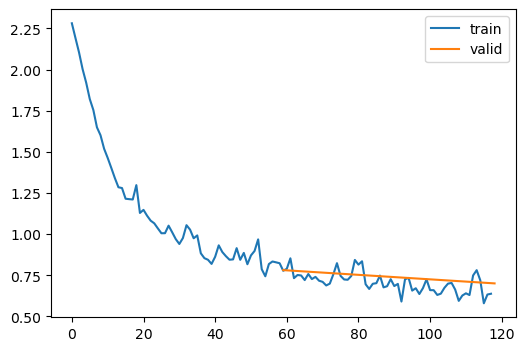

In [69]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore, we've replaced the context manager with a decorator in this updated version of `Learner`. We've also added a few more callbacks in `one_epoch()`.

In [71]:
class with_cbs:
    def __init__(self,nm): self.nm=nm
    def __call__(self,f):
        def _f(o,*args,**kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o,*args,**kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [72]:
class Learner():
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self.one_batch()
        
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()
    
    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs=n_epochs
            self.epochs=range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), lr=self.lr if lr is None else lr)
            self._fit(train,valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
        
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
        
    @property
    def training(self): return self.model.training

my_awesome_accuracy,loss,epoch,train
0.629,1.155,0,traing
0.714,0.793,0,eval


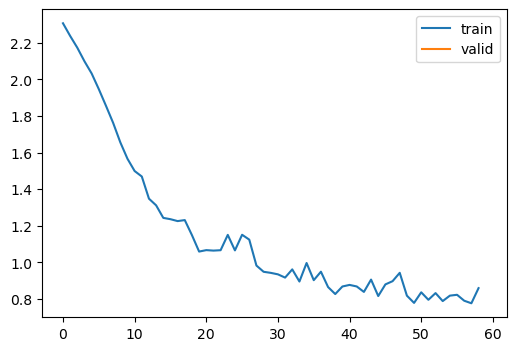

In [73]:
model = get_model()

metrics = MetricsCB(my_awesome_accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

Note Umer: `TrainLearner` will be a `Learner` with an implementation of the training process, meaning we don't need `TrainCB` anymore.

In [74]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.model.zero_grad()

In [76]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom=mom
        super().__init__(model,dls,loss_func,lr,cbs,opt_func)
        
        def zero_grad(self):
            with torch.no_grad():
                for p in self.model.parameters(): p.grad *= self.mom

Note Umer: To use momentum, we don't reset gradients to zero, but instead scale them down to 85% (tuned via `mom` argument).<br/>
So, the next gradients will be $\hat{g}_t = \hat{g}_{t-1}*0.85 + g_t$, where $\hat{g}$ are the actual gradients used for updating and $g$ are the unchanged gradients which we get from `backward`.

**Q:** Don't we need to scale down $g_t$ accordingly, so we get a convex combination? Like this, the gradients will be, on average, 1.85 times as big.

accuracy,loss,epoch,train
0.615,1.344,0,traing
0.711,0.885,0,eval


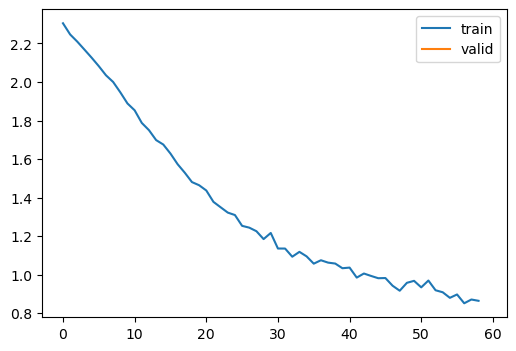

In [79]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

I would have expected te loss to be lower than without momentum. Maybe it's randomness? Let's try a few times.

In [95]:
class MetricsCBNoLog(MetricsCB):
    def _log(self,d): pass

def test_learn_strategy(learn_strategy):
    metrics = MetricsCBNoLog(accuracy=MulticlassAccuracy())
    cbs = [DeviceCB(), metrics]
    learn = learn_strategy(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
    learn.fit(1)
    return learn.metrics.all_metrics['loss'].compute()

In [96]:
test_learn_strategy(MomentumLearner)

tensor(0.90, dtype=torch.float64)

In [106]:
mom_results = tensor([test_learn_strategy(MomentumLearner) for _ in progress_bar(range(5))])

In [107]:
plain_results = tensor([test_learn_strategy(TrainLearner) for _ in progress_bar(range(5))])

In [112]:
f'{mom_results.mean().item():.3f} +/- {mom_results.std().item():.3f}'

'0.917 +/- 0.017'

In [113]:
f'{plain_results.mean().item():.3f} +/- {plain_results.std().item():.3f}'

'0.913 +/- 0.012'

No, these are still the same. So, in this case, we don't get a benefit from using momentum.<br/>
**Q:** Why not?

## LRFinderCB

In [128]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self,learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf
        
    def after_batch(self,learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > 3*self.min: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

Note Umer: A model can have multuple parameter groups. E.g., when differents parts of the model should be trained in differents ways.

In all our models so far, we only had 1 param group. We therefore use `learn.opt.param_groups[0]`

In [129]:
len(learn.opt.param_groups)

1

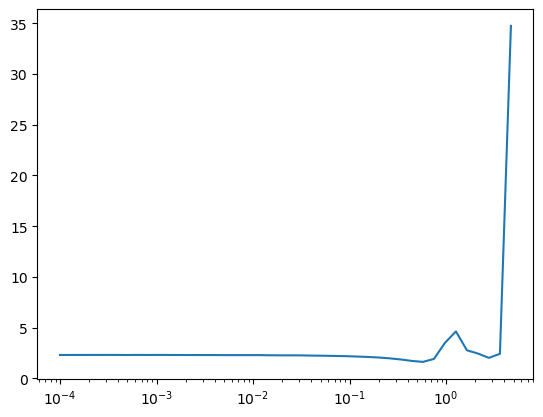

In [130]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

Note Umer: It's not guaranteed that all desired learning rates will be tested. As we only do `fit(1)`, it might be that one epoch is finished before all desired learning rates were tested.

**Q:** Why does this look so different from Jeremy's plot?

Instead of exponentially increasing the learning rate ourselves, we can use PyTorch's `ExponentialLR`

In [132]:
from torch.optim.lr_scheduler import ExponentialLR

In [133]:
class LRFinderCB(Callback):
    def __init__(self,gamma=1.3,max_mult=3): fc.store_attr()
    
    def before_fit(self,learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf
    
    def after_batch(self,learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.max_mult*self.min): raise CancelFitException()
        self.sched.step()
    
    def cleanup_fit(self,learn):
        plt.plot(self.lrs,self.losses)
        plt.xscale('log')

We have also moved the plotting into the cb.

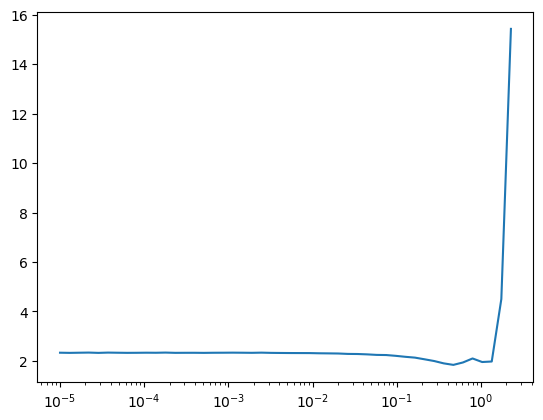

In [135]:
lrfinder = LRFinderCB()
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=lrfinder)

This also looks very different from Jeremy's plot. Maybe it's because of the zoom?

(1.0, 5.1)

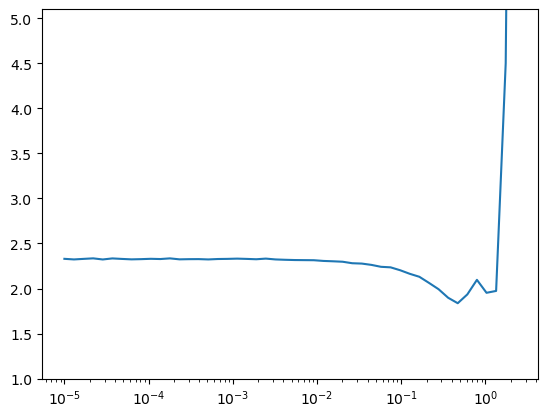

In [136]:
plt.plot(lrfinder.lrs,lrfinder.losses)
plt.xscale('log')
plt.ylim(1,5.1)

Zoomed in, this looks a bit better. The steepest slope is at the same place as in Jeremy's plot.

**Q:** We're using the same data and code. I would have expected the plots to me more similar. Why are they not?

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`:

In [137]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

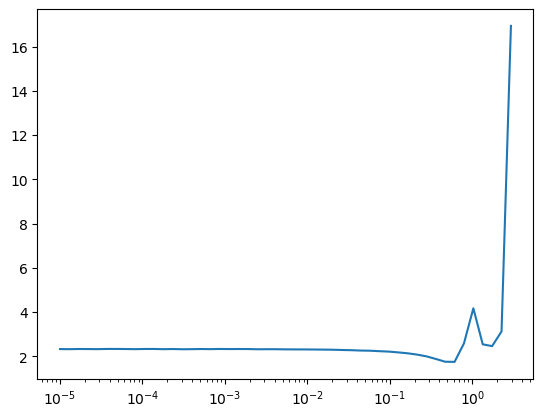

In [138]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()